In [7]:
import h5py
from fastmri.data.transforms import VarNetDataTransform, UnetDataTransform
from fastmri.data import SliceDataset
file = "file1001763.h5"
filename = "/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped/singlecoil_val/" + file
hf = h5py.File(filename)
slice = hf['kspace'][()][20]

In [11]:
from fastmri.data.transforms import to_tensor, tensor_to_complex_np
import fastmri, torch
from typing import Tuple
def kspace_to_mri(kspace: torch.Tensor, crop_size: Tuple[int,int] = (320,320)):
    slice_image = fastmri.ifft2c(kspace)
    slice_image_abs = fastmri.complex_abs(slice_image) 
    if crop_size is not None:
        slice_image_abs = fastmri.data.transforms.center_crop(slice_image_abs, crop_size)
    return slice_image_abs
x = to_tensor(slice)
x = kspace_to_mri(x)

In [9]:
import matplotlib.pyplot as plt
from fastmri.data.transforms import to_tensor, tensor_to_complex_np
import numpy as np
import torch
from torchvision import transforms as T
def show_coils(data, cmap=None):
    fig = plt.figure()
    plt.imshow(data, cmap=cmap)


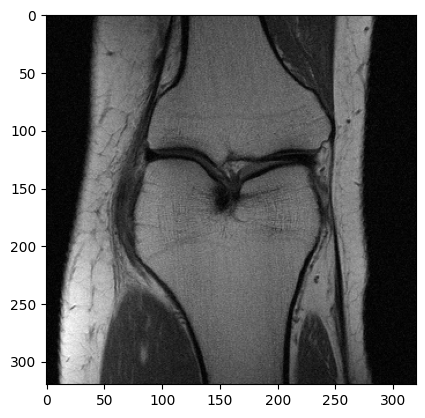

In [12]:
import numpy as np
import matplotlib.pyplot as plt
show_coils(x, cmap="gray")


tensor(-13.3731) tensor(3.5231)


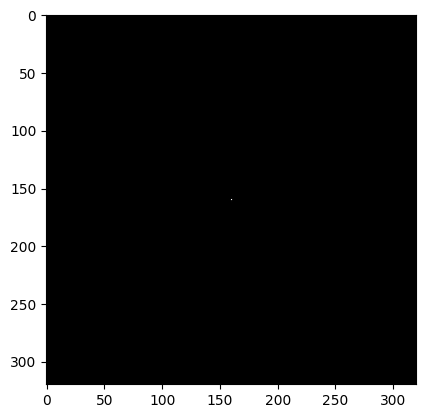

In [18]:
import fastmri.data
import fastmri.data.transforms
import torch
import fastmri

slice_kspace2 = T.to_tensor(slice)      # Convert from numpy array to pytorch tensor
print(slice_kspace2.min(), slice_kspace2.max())
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image) 
slice_image_abs = T.center_crop(slice_image_abs, (320,320))
show_coils(slice_image_abs, cmap="gray")

In [10]:
import torch

x = torch.randn(1,2,320,320)
shape = x.shape
y = x.flatten()

y.view(shape).shape

torch.Size([1, 2, 320, 320])

In [ ]:
from pl_modules.data_module import LDMLatentDataModule
from modules.transforms import norm
from pathlib import Path
dm = LDMLatentDataModule(
    data_path=Path("latent_data/latent_data/"),
    challenge="singlecoil",
    batch_size=1,
    num_workers=4, 
)

/vol/ideadata/ce84pegu/kspace-diffusion/kdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pl_modules.data_module import LatentDataset
from pathlib import Path
ds = LatentDataset(
    root=Path("latent_data/latent_data/singlecoil_train"),
    challenge="singlecoil"
)

In [ ]:
ds.__len__()

34742

In [2]:
import pytorch_lightning as pl
from pl_modules.ldm_module import LDM
from pl_modules.data_module import LDMLatentDataModule
from pathlib import Path
dm = LDMLatentDataModule(
    data_path=Path("latent_data/latent_data/"),
    challenge="singlecoil",
    batch_size=1,
    num_workers=4, 
)
model = LDM(16, 16)
trainer = pl.Trainer(max_epochs=100)
dm.setup("fit")
dl = dm.train_dataloader()
trainer.fit(model, dl)
# for batch in dl:
#     print(batch.full_latent_tensor.shape)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | UNet2DModel | 16.1 M | train
----------------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.286    Total estimated model params size (MB)
261       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 98/34742 [00:51<5:01:41,  1.91it/s, v_num=18, train/mse_noise_loss_step=0.628]torch.Size([1, 16, 80, 48])



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [2]:
from fastmri.pl_modules import FastMriDataModule
from fastmri.data.subsample import create_mask_for_mask_type
from pathlib import Path
from modules.transforms import KspaceUNetDataTransform

config = {
        "mask_type": "equispaced_fraction",
        "center_fractions": [0.04],
        "accelerations": [8],
        "loss_domain": "kspace", 
        "n_channels": 32,
        "with_residual": False,
        "latent_dim": 128,
        "mode": "interpolation"
    }

mask_func = create_mask_for_mask_type(
    config["mask_type"], config["center_fractions"], config["accelerations"]
)
train_transform = KspaceUNetDataTransform(mask_func=mask_func, use_seed=False, adapt_pool=False)
val_transform = KspaceUNetDataTransform(mask_func=mask_func)
test_transform = KspaceUNetDataTransform()
data_module = FastMriDataModule(
        data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
        challenge="singlecoil",
        train_transform=train_transform,
        val_transform=val_transform,
        test_transform=test_transform,
        combine_train_val=False,
        test_split="test",
        sample_rate=None,
        batch_size=1,
        num_workers=4,
        distributed_sampler=False,
        use_dataset_cache_file=True
    )

In [3]:
shapes = []
for i, batch in enumerate(data_module.train_dataloader()):
    if i > 2000:
        break
    shapes.append(batch.full_kspace.shape[-2])

In [4]:
from collections import Counter

Counter(shapes)

Counter({368: 1126,
         372: 743,
         322: 45,
         320: 22,
         388: 17,
         338: 15,
         370: 10,
         386: 7,
         400: 5,
         550: 5,
         356: 3,
         480: 2,
         640: 1})

In [5]:
import numpy as np

print(np.mean(shapes))

368.7056471764118
